In [1]:
# Configure amd test GPU
import tensorflow as tf
from tensorflow.python.client import device_lib

# Prevent automatic GPU memory pre-allocation
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print(gpu)
    tf.config.experimental.set_memory_growth(gpu, True)

print(tf.__version__)
# print(device_lib.list_local_devices())

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
2.9.1


In [2]:
# Load the SNR10 dataset
import os

print(os.getcwd())
os.chdir('../datasets')
print(os.getcwd())

/home/jovyan/committed_git/data_augmentation
/home/jovyan/committed_git/datasets


In [3]:
# may delete later
# New way to import the data
import h5py
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Open HDF5 file and access the dataset
filename = 'dataset_SNR20_outdoor.mat'
hdf5_file = h5py.File(filename, 'r')

features_dataset = hdf5_file['features']
labels_dataset = hdf5_file['labels']['position']

# Convert HDF5 dataset to NumPy array
features = np.array(features_dataset)
labels = np.array(labels_dataset)

# Prepare features for dataset
# Retrieve features from the first UE and transpose the individual matrix
features_transposed = np.zeros((3876,193,16), dtype = np.float64)
for i in range(len(features)):
    features_transposed[i] = features[i][0].T

# Prepare labels for dataset
count = 0
rp_dict = {}
# For labels, have a shape of (1,) where that number represents the class of that coordinate

for label in labels:
    rp_dict[count] = label
    count += 1

labels = np.array([i for i in range(3876)])

# Close the HDF5 file
hdf5_file.close()

# Currently, for features, have features from 3876 reference points, from 4 UEs, for (16,193) matrices
print(features_transposed.shape)
print(labels.shape)

(3876, 193, 16)
(3876,)


## Data Augmentation Method 1: Perform barrel rolling
- Given an image height of 193, barrel roll the image downwards vertically by 40,80,120 and 160 - to generate 4 augmented images per fingerprint
- Given an image height of 193, barrel roll the image upwards vertically by 30, 60, 90, 120 - to generate 4 augmented images per fingerprint

(193, 16)


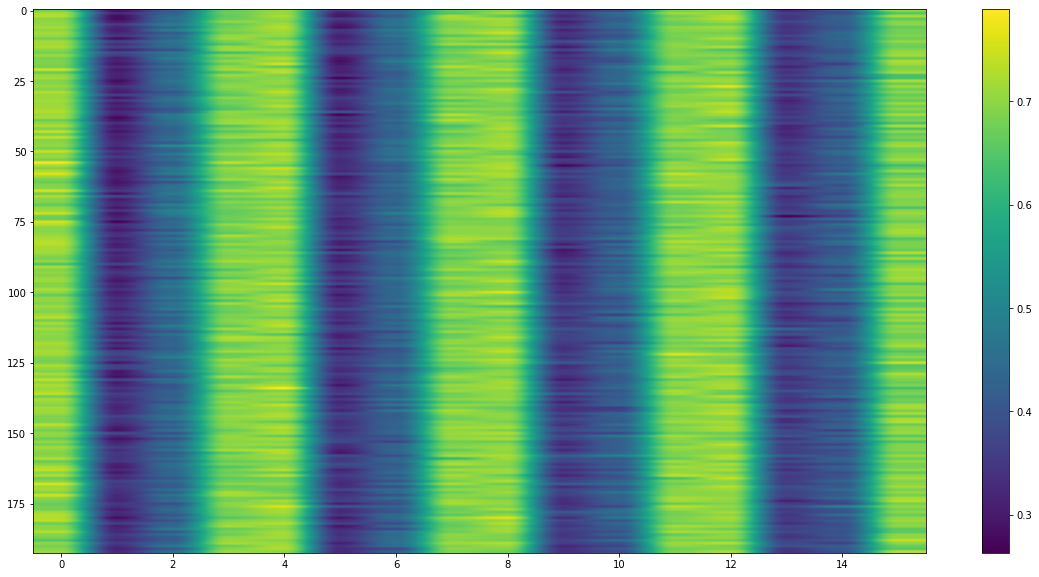

In [4]:
sample_feature = features_transposed[0]
print(sample_feature.shape)

plt.rcParams['figure.figsize'] = [20, 10]
plt.colorbar(plt.imshow(sample_feature))
plt.imshow(sample_feature, aspect = 'auto')

In [5]:
# Test barrel rolling on new sample
augmented_samples = np.zeros((4, *sample_feature.shape), dtype = np.float64)
for i in range(4):
    
    # step size of 40
    translation_factor = (i + 1)*40
    
    for j in range(len(sample_feature)):
        
        new_index = (j + translation_factor) % len(sample_feature)
        augmented_samples[i][new_index] = sample_feature[j]
        
print(augmented_samples.shape)

(4, 193, 16)


In [13]:
def get_ssim_value(fp1, fp2):
    
    fp1 = np.expand_dims(fp1, axis = 2)
    fp2 = np.expand_dims(fp2, axis = 2)
    return tf.image.ssim(fp1, fp2, max_val=1.0, filter_size=11,
                          filter_sigma=1.5, k1=0.01, k2=0.03).numpy()

### Barrel roll downwards vertically

2023-07-06 01:08:21.890509: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 01:08:22.413817: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 39939 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:25:00.0, compute capability: 8.6
2023-07-06 01:08:23.957506: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401


SSIM index: 0.9813327789306641
SSIM index: 0.9809092283248901
SSIM index: 0.9799606800079346
SSIM index: 0.9812519550323486
SSIM index: 0.9818703532218933


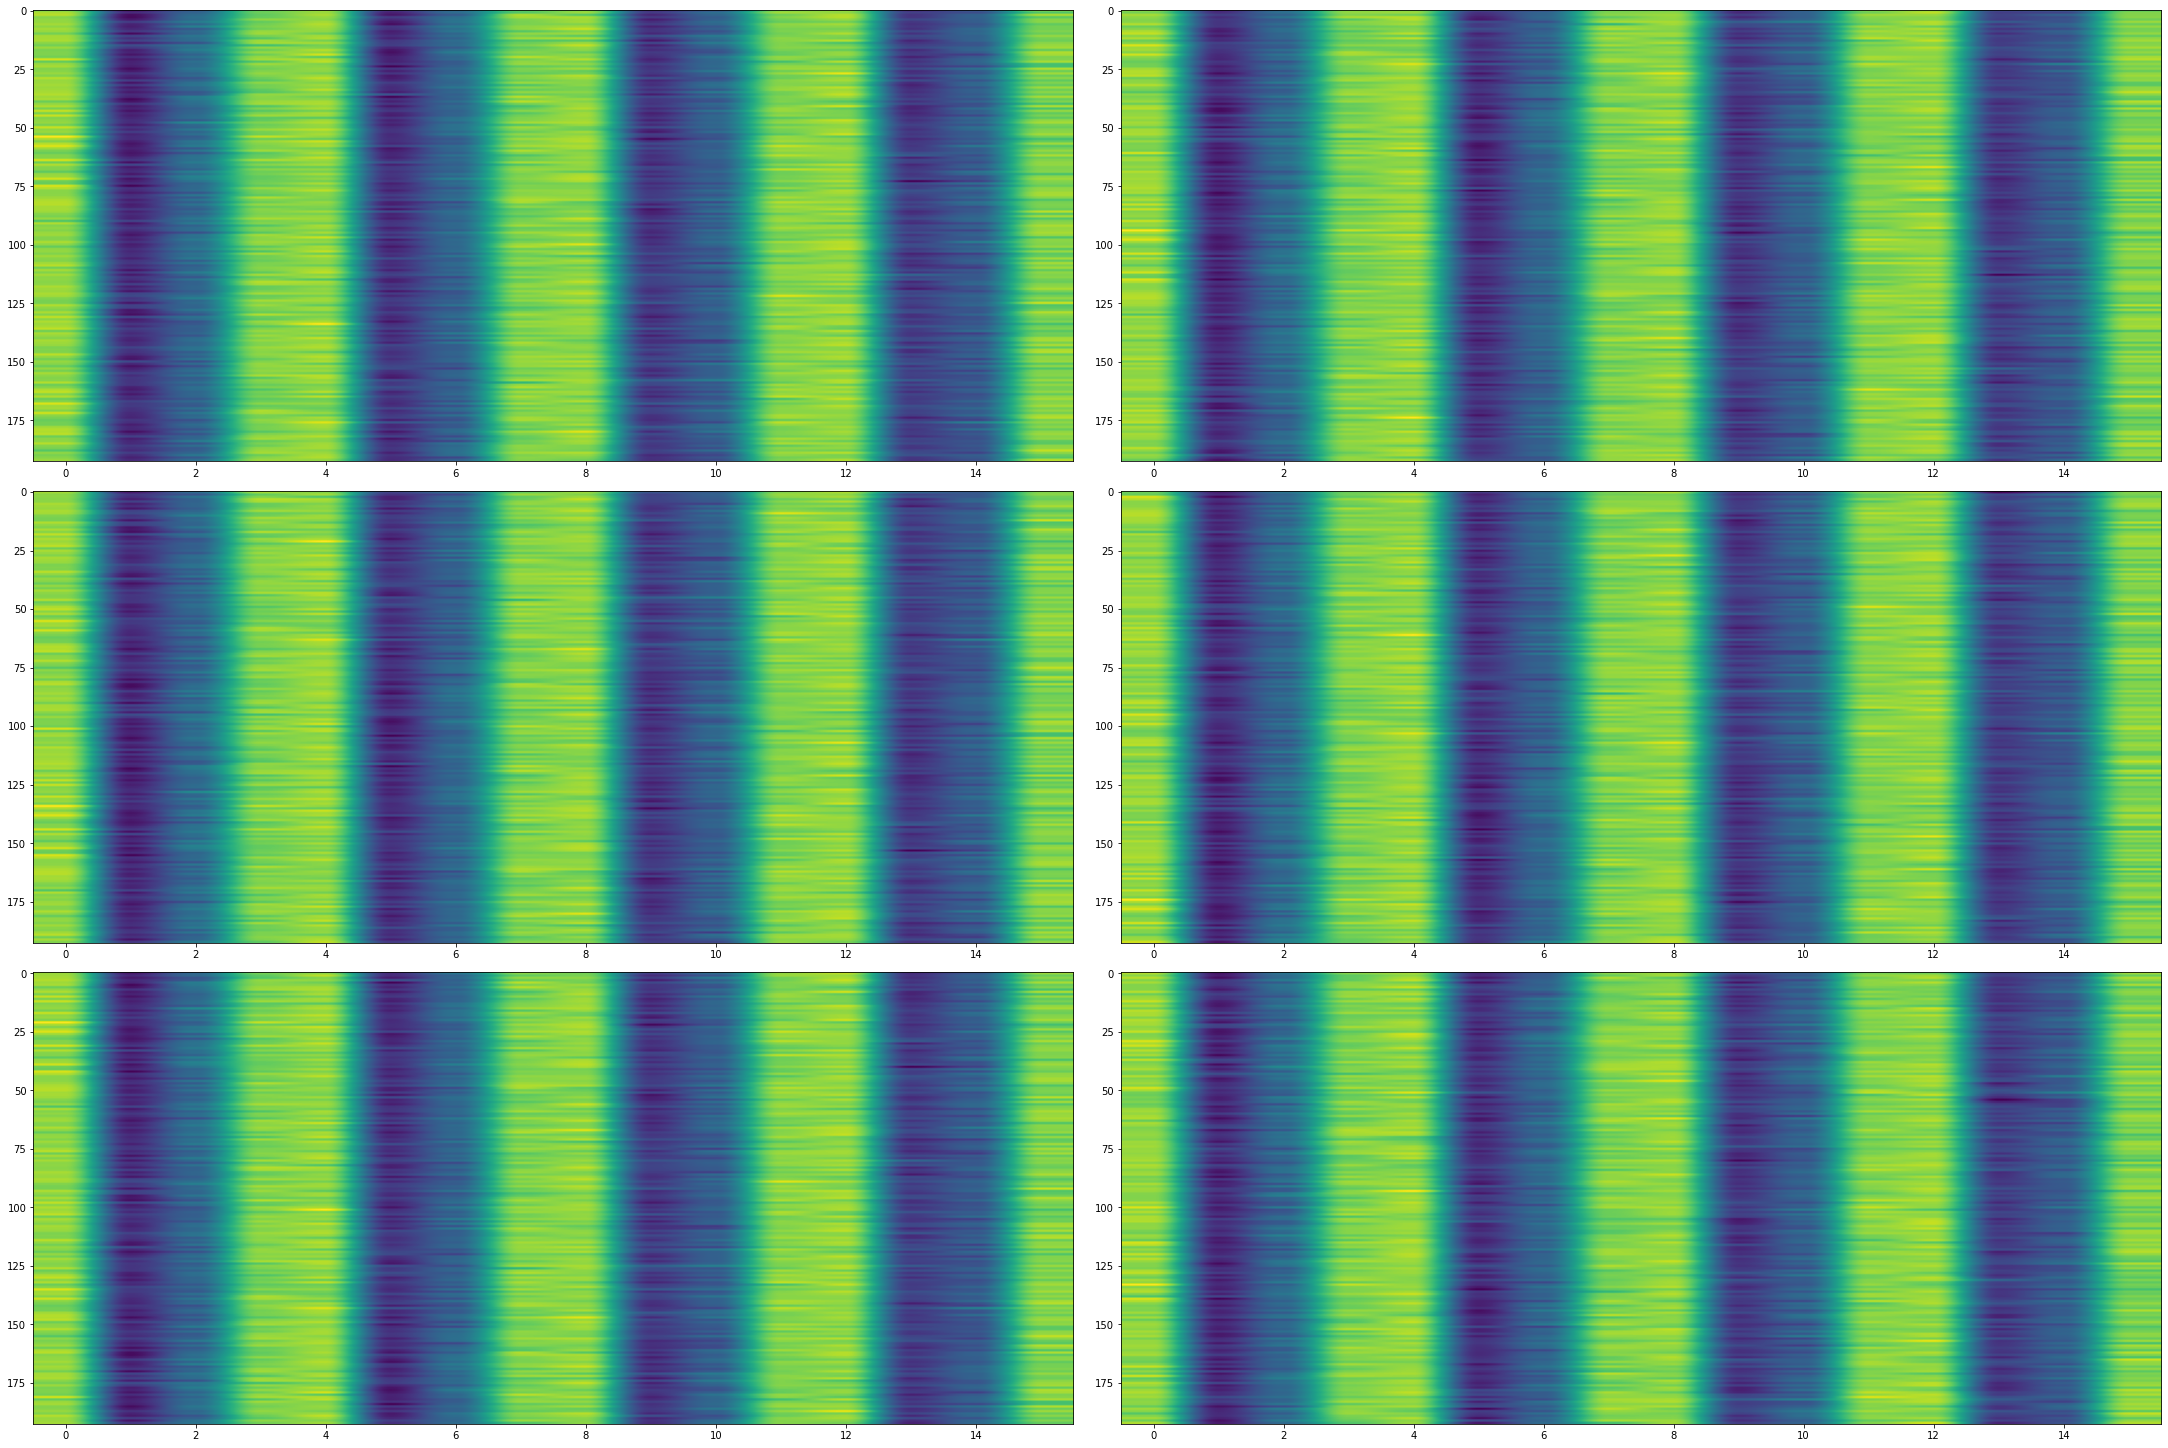

In [8]:
plt.rcParams['figure.figsize'] = [30, 20]
fig, axs = plt.subplots(3,2, constrained_layout = True)

axs[0,0].imshow(sample_feature, aspect = 'auto')
axs[0,1].imshow(augmented_samples[0], aspect = 'auto')
print(f'SSIM index: {get_ssim_value(sample_feature, augmented_samples[0])}')

axs[1,0].imshow(augmented_samples[1], aspect = 'auto')
print(f'SSIM index: {get_ssim_value(sample_feature, augmented_samples[1])}')

axs[1,1].imshow(augmented_samples[2], aspect = 'auto')
print(f'SSIM index: {get_ssim_value(sample_feature, augmented_samples[2])}')

axs[2,0].imshow(augmented_samples[3], aspect = 'auto')
print(f'SSIM index: {get_ssim_value(sample_feature, augmented_samples[3])}')

sample_copy = np.copy(sample_feature)
np.random.shuffle(sample_copy)
axs[2,1].imshow(sample_copy, aspect = 'auto')
print(f'SSIM index: {get_ssim_value(sample_feature, sample_copy)}')

### Barrel roll upwards vertically

In [14]:
# Test barrel rolling on new sample
augmented_samples = np.zeros((4, *sample_feature.shape), dtype = np.float64)
for i in range(4):
    
    # step size of 40
    translation_factor = (i + 1)*30
    
    for j in range(len(sample_feature)):
        
        new_index = (j - translation_factor) % len(sample_feature)
        augmented_samples[i][new_index] = sample_feature[j]
        
print(augmented_samples.shape)

(4, 193, 16)


SSIM index: 0.9814984798431396
SSIM index: 0.9799336791038513
SSIM index: 0.9803602695465088
SSIM index: 0.9800199270248413
SSIM index: 0.9810613989830017


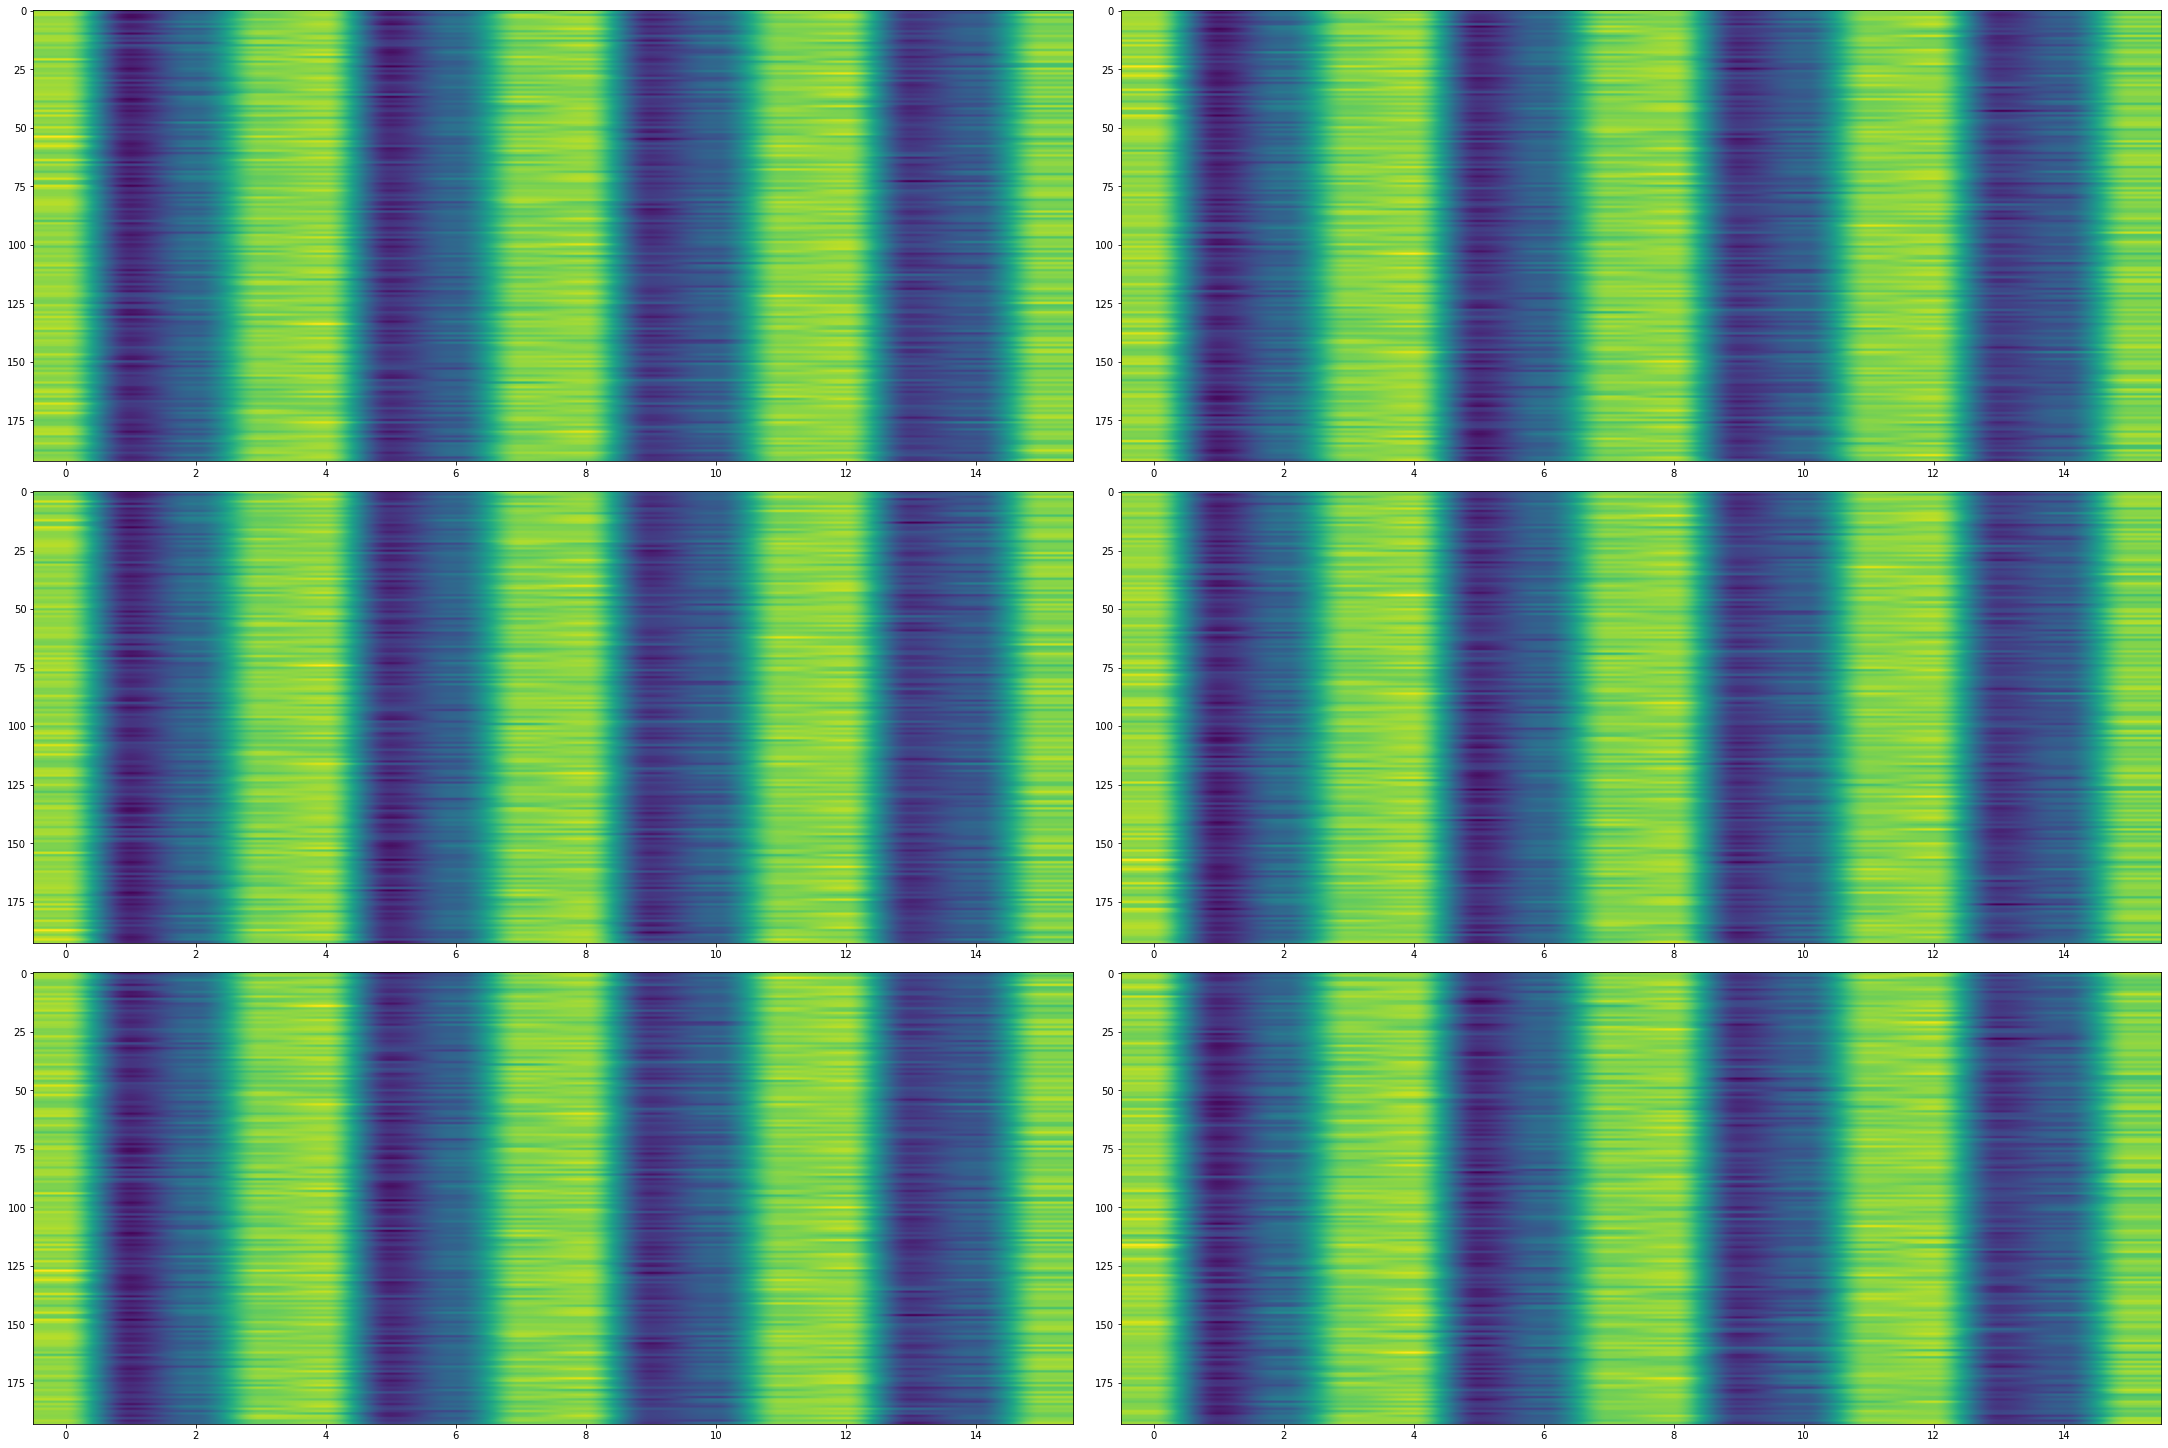

In [15]:
plt.rcParams['figure.figsize'] = [30, 20]
fig, axs = plt.subplots(3,2, constrained_layout = True)

axs[0,0].imshow(sample_feature, aspect = 'auto')
axs[0,1].imshow(augmented_samples[0], aspect = 'auto')
print(f'SSIM index: {get_ssim_value(sample_feature, augmented_samples[0])}')

axs[1,0].imshow(augmented_samples[1], aspect = 'auto')
print(f'SSIM index: {get_ssim_value(sample_feature, augmented_samples[1])}')

axs[1,1].imshow(augmented_samples[2], aspect = 'auto')
print(f'SSIM index: {get_ssim_value(sample_feature, augmented_samples[2])}')

axs[2,0].imshow(augmented_samples[3], aspect = 'auto')
print(f'SSIM index: {get_ssim_value(sample_feature, augmented_samples[3])}')

sample_copy = np.copy(sample_feature)
np.random.shuffle(sample_copy)
axs[2,1].imshow(sample_copy, aspect = 'auto')
print(f'SSIM index: {get_ssim_value(sample_feature, sample_copy)}')

In [31]:
# Create the augmented dataset with barrel rolled images

def roll_downwards(feature, factor, num_samples):
    
    # Test barrel rolling on new sample
    augmented_samples = np.zeros((num_samples, *feature.shape), dtype = np.float64)
    for i in range(num_samples):

        # step size of 40
        translation_factor = (i + 1)*factor

        for j in range(len(feature)):

            new_index = (j + translation_factor) % len(feature)
            augmented_samples[i][new_index] = feature[j]

    return augmented_samples

def roll_upwards(feature, factor, num_samples):
    
    # Test barrel rolling on new sample
    augmented_samples = np.zeros((num_samples, *feature.shape), dtype = np.float64)
    for i in range(num_samples):

        # step size of 40
        translation_factor = (i + 1)*factor

        for j in range(len(feature)):

            new_index = (j - translation_factor) % len(feature)
            augmented_samples[i][new_index] = feature[j]

    return augmented_samples

def barrelroll_augment_ds(filename, down_factor, down_numsamples, up_factor, up_numsamples):
    
    # Open HDF5 file and access the dataset
    hdf5_file = h5py.File(filename, 'r')

    features_dataset = hdf5_file['features']
    labels_dataset = hdf5_file['labels']['position']

    # Convert HDF5 dataset to NumPy array
    features = np.array(features_dataset)
    labels = np.array(labels_dataset)

    # Prepare features for dataset
    # Retrieve features from the first UE and transpose the individual matrix
    features_transposed = np.zeros((3876,193,16), dtype = np.float64)
    for i in range(len(features)):
        features_transposed[i] = features[i][0].T

    # Prepare labels for dataset
    count = 0
    rp_dict = {}
    # For labels, have a shape of (1,) where that number represents the class of that coordinate

    for label in labels:
        rp_dict[count] = label
        count += 1

    labels = np.array([i for i in range(3876)])

    # Close the HDF5 file
    hdf5_file.close()

    # Currently, for features, have features from 3876 reference points, from 4 UEs, for (16,193) matrices
    # print(features_transposed.shape)
    # print(labels.shape)
    
    generated_features = []
    generated_labels = []
    
    for index, feature in enumerate(features_transposed):
        
        # Append original feature
        generated_features.append(feature)
        
        # Barrel roll downwards
        # Roll downwards at a factor of 40 to generate 4 augmented samples
        downwards_roll_samples = roll_downwards(feature, down_factor, down_numsamples)
       
        for i in range(len(downwards_roll_samples)):
            generated_features.append(downwards_roll_samples[i])
        
        # Barrel roll upwards
        # Roll upwards at a factor of 30 to generate 4 augmented samples
        upwards_roll_samples = roll_upwards(feature, up_factor, up_numsamples)
        
        for i in range(len(upwards_roll_samples)):
            generated_features.append(upwards_roll_samples[i])
        
        labels = [index] * (1 + down_numsamples + up_numsamples)
        generated_labels.extend(labels)
    
    np_generated_features = np.array(generated_features)
    np_generated_labels = np.array(generated_labels)
    
    return np_generated_features, np_generated_labels

In [32]:
# filename = 'dataset_SNR10_outdoor.mat'
features_snr10, coords_snr10 = barrelroll_augment_ds('dataset_SNR10_outdoor.mat', 40, 4, 30, 4)
print(features_snr10.shape, coords_snr10.shape)

(34884, 193, 16) (34884,)


In [34]:
# filename = 'dataset_SNR20_outdoor.mat'
features_snr20, coords_snr20 = barrelroll_augment_ds('dataset_SNR20_outdoor.mat', 40, 4, 30, 4)
print(features_snr20.shape, coords_snr20.shape)

(34884, 193, 16) (34884,)


In [33]:
# filename = 'dataset_SNR50_outdoor.mat'
features_snr50, coords_snr50 = barrelroll_augment_ds('dataset_SNR50_outdoor.mat', 40, 4, 30, 4)
print(features_snr50.shape, coords_snr50.shape)

(34884, 193, 16) (34884,)


In [35]:
features = np.concatenate((features_snr10, features_snr20, features_snr50), axis = 0)
labels = np.concatenate((coords_snr10, coords_snr20, coords_snr50), axis = 0)

In [36]:
# Confirm shapes to confirm correctness
print(features.shape, labels.shape)

# Save data into numpy files
np.save('augmented_features_8_ue1_br_ds', features)
np.save('augmented_labels_8_ue1_br_ds', labels)

(104652, 193, 16) (104652,)


## Data Augmentation Method 2: Additive Gaussian Noise
- 5 augmented fingerprint images per sample, with mean 0 and standard deviation 4

In [17]:
# Note: Every colummn refers to measurements from same frequency channel, at different time intervals
# Add noise according to the mean and std of values along the column

# Delete later
import math
max_val = -math.inf

def add_gaussian_noise(feature):
    
    global max_val
    
    num_rows, num_cols = feature.shape[0], feature.shape[1]
    noisy = feature.copy()
    
    # Iterate along the columns of each image
    for i in range(num_cols):
        
        # Get all values in that same column
        channel_values = feature[:,i]
        channel_std = np.std(channel_values)
        channel_mean = np.mean(channel_values)
        
        # Create normal distribution according to std of values with mean 0
        gauss = np.random.normal(0, 4 * channel_std, (num_rows))
        noisy[:,i] = feature[:,i] + gauss
     
    noisy[noisy < 0] = 0
    
    # Delete later
    cur_max = np.amax(noisy)
    if cur_max > max_val:
        max_val = cur_max
    
    feature = np.expand_dims(feature, axis = 2)
    noisy = np.expand_dims(noisy, axis = 2)

    ssim_value = tf.image.ssim(feature, noisy, max_val=2.0, filter_size=11,
                      filter_sigma=1.5, k1=0.01, k2=0.03).numpy()

    # plt.imshow(noisy, aspect = 'auto')
    return (ssim_value, noisy)

In [18]:
# This function takes in dataset in the numpy format
import h5py
import numpy as np
import tensorflow as tf

def augment_ds(filename):
    
    # Open HDF5 file and access the dataset

    hdf5_file = h5py.File(filename, 'r')

    features_dataset = hdf5_file['features']
    labels_dataset = hdf5_file['labels']['position']

    # Convert HDF5 dataset to NumPy array
    features = np.array(features_dataset)
    labels = np.array(labels_dataset)

    # Prepare features for dataset
    # Retrieve features from the first UE and transpose the individual matrix
    features_transposed = np.zeros((3876,193,16), dtype = np.float64)
    for i in range(len(features)):
        features_transposed[i] = features[i][0].T

    # Prepare labels for dataset
    count = 0
    rp_dict = {}
    # For labels, have a shape of (1,) where that number represents the class of that coordinate

    for label in labels:
        rp_dict[count] = label
        count += 1

    labels = np.array([i for i in range(3876)])

    # Close the HDF5 file
    hdf5_file.close()

    # Currently, for features, have features from 3876 reference points, from 4 UEs, for (16,193) matrices
    print(features_transposed.shape)
    print(labels.shape)
   
    generated_features = []
    generated_coords = []
    
    # Iterate through each feature
    for index, feature in enumerate(features_transposed):
            
        generated_count = 0
        attempts = 0
        
        # while 5 noisy images have not been generated yet,
        while generated_count < 5:
            
            if attempts > 25:
                print(f'Unable to generate data. Index: {index}')
                break
                
            similarity_val, noisy_img = add_gaussian_noise(feature)
            
            # if images are not similar enough,
            if similarity_val >= 0.5:
                generated_features.append(noisy_img)
                generated_coords.append(index)
                generated_count += 1
            
            attempts += 1
            
    print("Finish augmenting")
    
    np_generated_features = np.array(generated_features)
    np_generated_features = np.squeeze(np_generated_features, axis=(3,))
    np_generated_coords = np.array(generated_coords)
   
    print("Finish making numpy arrays")

    all_features = np.concatenate((features_transposed, np_generated_features), axis = 0)
    all_coords = np.concatenate((labels, np_generated_coords), axis = 0)
    
    print("Finish concatenating numpy arrays")

    return all_features, all_coords

In [19]:
# filename = 'dataset_SNR10_outdoor.mat'
features_snr10, coords_snr10 = augment_ds('dataset_SNR10_outdoor.mat')
print(features_snr10.shape, coords_snr10.shape)

(3876, 193, 16)
(3876,)
Unable to generate data. Index: 23
Unable to generate data. Index: 24
Unable to generate data. Index: 25
Unable to generate data. Index: 26
Unable to generate data. Index: 27
Unable to generate data. Index: 28
Unable to generate data. Index: 29
Unable to generate data. Index: 30
Unable to generate data. Index: 31
Unable to generate data. Index: 32
Unable to generate data. Index: 33
Unable to generate data. Index: 53
Unable to generate data. Index: 54
Unable to generate data. Index: 55
Unable to generate data. Index: 66
Unable to generate data. Index: 67
Unable to generate data. Index: 74
Unable to generate data. Index: 85
Unable to generate data. Index: 86
Unable to generate data. Index: 93
Unable to generate data. Index: 94
Unable to generate data. Index: 95
Unable to generate data. Index: 96
Unable to generate data. Index: 97
Unable to generate data. Index: 99
Unable to generate data. Index: 100
Unable to generate data. Index: 101
Unable to generate data. Inde

In [20]:
# filename = 'dataset_SNR20_outdoor.mat'
features_snr20, coords_snr20 = augment_ds('dataset_SNR20_outdoor.mat')
print(features_snr20.shape, coords_snr20.shape)

(3876, 193, 16)
(3876,)
Unable to generate data. Index: 33
Unable to generate data. Index: 66
Unable to generate data. Index: 67
Unable to generate data. Index: 99
Unable to generate data. Index: 100
Unable to generate data. Index: 101
Unable to generate data. Index: 132
Unable to generate data. Index: 133
Unable to generate data. Index: 134
Unable to generate data. Index: 135
Unable to generate data. Index: 165
Unable to generate data. Index: 166
Unable to generate data. Index: 167
Unable to generate data. Index: 168
Unable to generate data. Index: 169
Unable to generate data. Index: 198
Unable to generate data. Index: 199
Unable to generate data. Index: 200
Unable to generate data. Index: 201
Unable to generate data. Index: 202
Unable to generate data. Index: 203
Unable to generate data. Index: 231
Unable to generate data. Index: 232
Unable to generate data. Index: 233
Unable to generate data. Index: 234
Unable to generate data. Index: 235
Unable to generate data. Index: 236
Unable t

In [21]:
# filename = 'dataset_SNR50_outdoor.mat'
features_snr50, coords_snr50 = augment_ds('dataset_SNR50_outdoor.mat')
print(features_snr50.shape, coords_snr50.shape)

(3876, 193, 16)
(3876,)
Unable to generate data. Index: 33
Unable to generate data. Index: 66
Unable to generate data. Index: 67
Unable to generate data. Index: 99
Unable to generate data. Index: 100
Unable to generate data. Index: 101
Unable to generate data. Index: 132
Unable to generate data. Index: 133
Unable to generate data. Index: 134
Unable to generate data. Index: 135
Unable to generate data. Index: 165
Unable to generate data. Index: 166
Unable to generate data. Index: 167
Unable to generate data. Index: 168
Unable to generate data. Index: 169
Unable to generate data. Index: 198
Unable to generate data. Index: 199
Unable to generate data. Index: 200
Unable to generate data. Index: 201
Unable to generate data. Index: 202
Unable to generate data. Index: 203
Unable to generate data. Index: 231
Unable to generate data. Index: 232
Unable to generate data. Index: 233
Unable to generate data. Index: 234
Unable to generate data. Index: 235
Unable to generate data. Index: 236
Unable t

In [22]:
print(max_val)

4.228228600647184


In [23]:
features = np.concatenate((features_snr10, features_snr20, features_snr50), axis = 0)
labels = np.concatenate((coords_snr10, coords_snr20, coords_snr50), axis = 0)

In [24]:
# Confirm shapes to confirm correctness
print(features.shape, labels.shape)

# Save data into numpy files
np.save('augmented_features_5_ue1_v1_ds', features)
np.save('augmented_labels_5_ue1_v1_ds', labels)

(24152, 193, 16) (24152,)


## Data Augmentation Method 3: Multi-Layer Regression (MLR)

- Use a FC feed-forward NN to learn the function that maps a set of coordinate to the mean and variance of signal measurements for the 16 subcarriers at each reference point

In [39]:
# may delete later
# New way to import the data
import h5py
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Open HDF5 file and access the dataset
filename = 'dataset_SNR20_outdoor.mat'
hdf5_file = h5py.File(filename, 'r')

features_dataset = hdf5_file['features']
labels_dataset = hdf5_file['labels']['position']

# Convert HDF5 dataset to NumPy array
features = np.array(features_dataset)
labels = np.array(labels_dataset)

# Prepare features for dataset
# Retrieve features from the first UE and transpose the individual matrix
features_transposed = np.zeros((3876,193,16), dtype = np.float64)
for i in range(len(features)):
    features_transposed[i] = features[i][0].T

# Prepare labels for dataset
count = 0
rp_dict = {}
# For labels, have a shape of (1,) where that number represents the class of that coordinate

for label in labels:
    rp_dict[count] = label
    count += 1

labels = np.array([i for i in range(3876)])

# Close the HDF5 file
hdf5_file.close()

# Currently, for features, have features from 3876 reference points, from 4 UEs, for (16,193) matrices
print(features_transposed.shape)
print(labels.shape)

(3876, 193, 16)
(3876,)


In [64]:
# Extract the signal measurements from each of the 16 channels at all the RPs and analyse their mean
# and variance

def get_mean_variance(features, channel_no):
    
    means = []
    variances = []
    
    for feature in features:
        
        channel_measurements = feature[:,channel_no]
        means.append(np.mean(channel_measurements))
        variances.append(np.var(channel_measurements))
        
    return means, variances

means = []
variances = []

for i in range(16):
    channel_means, channel_variances = get_mean_variance(features_transposed, i)
    means.append(channel_means)
    variances.append(channel_variances)

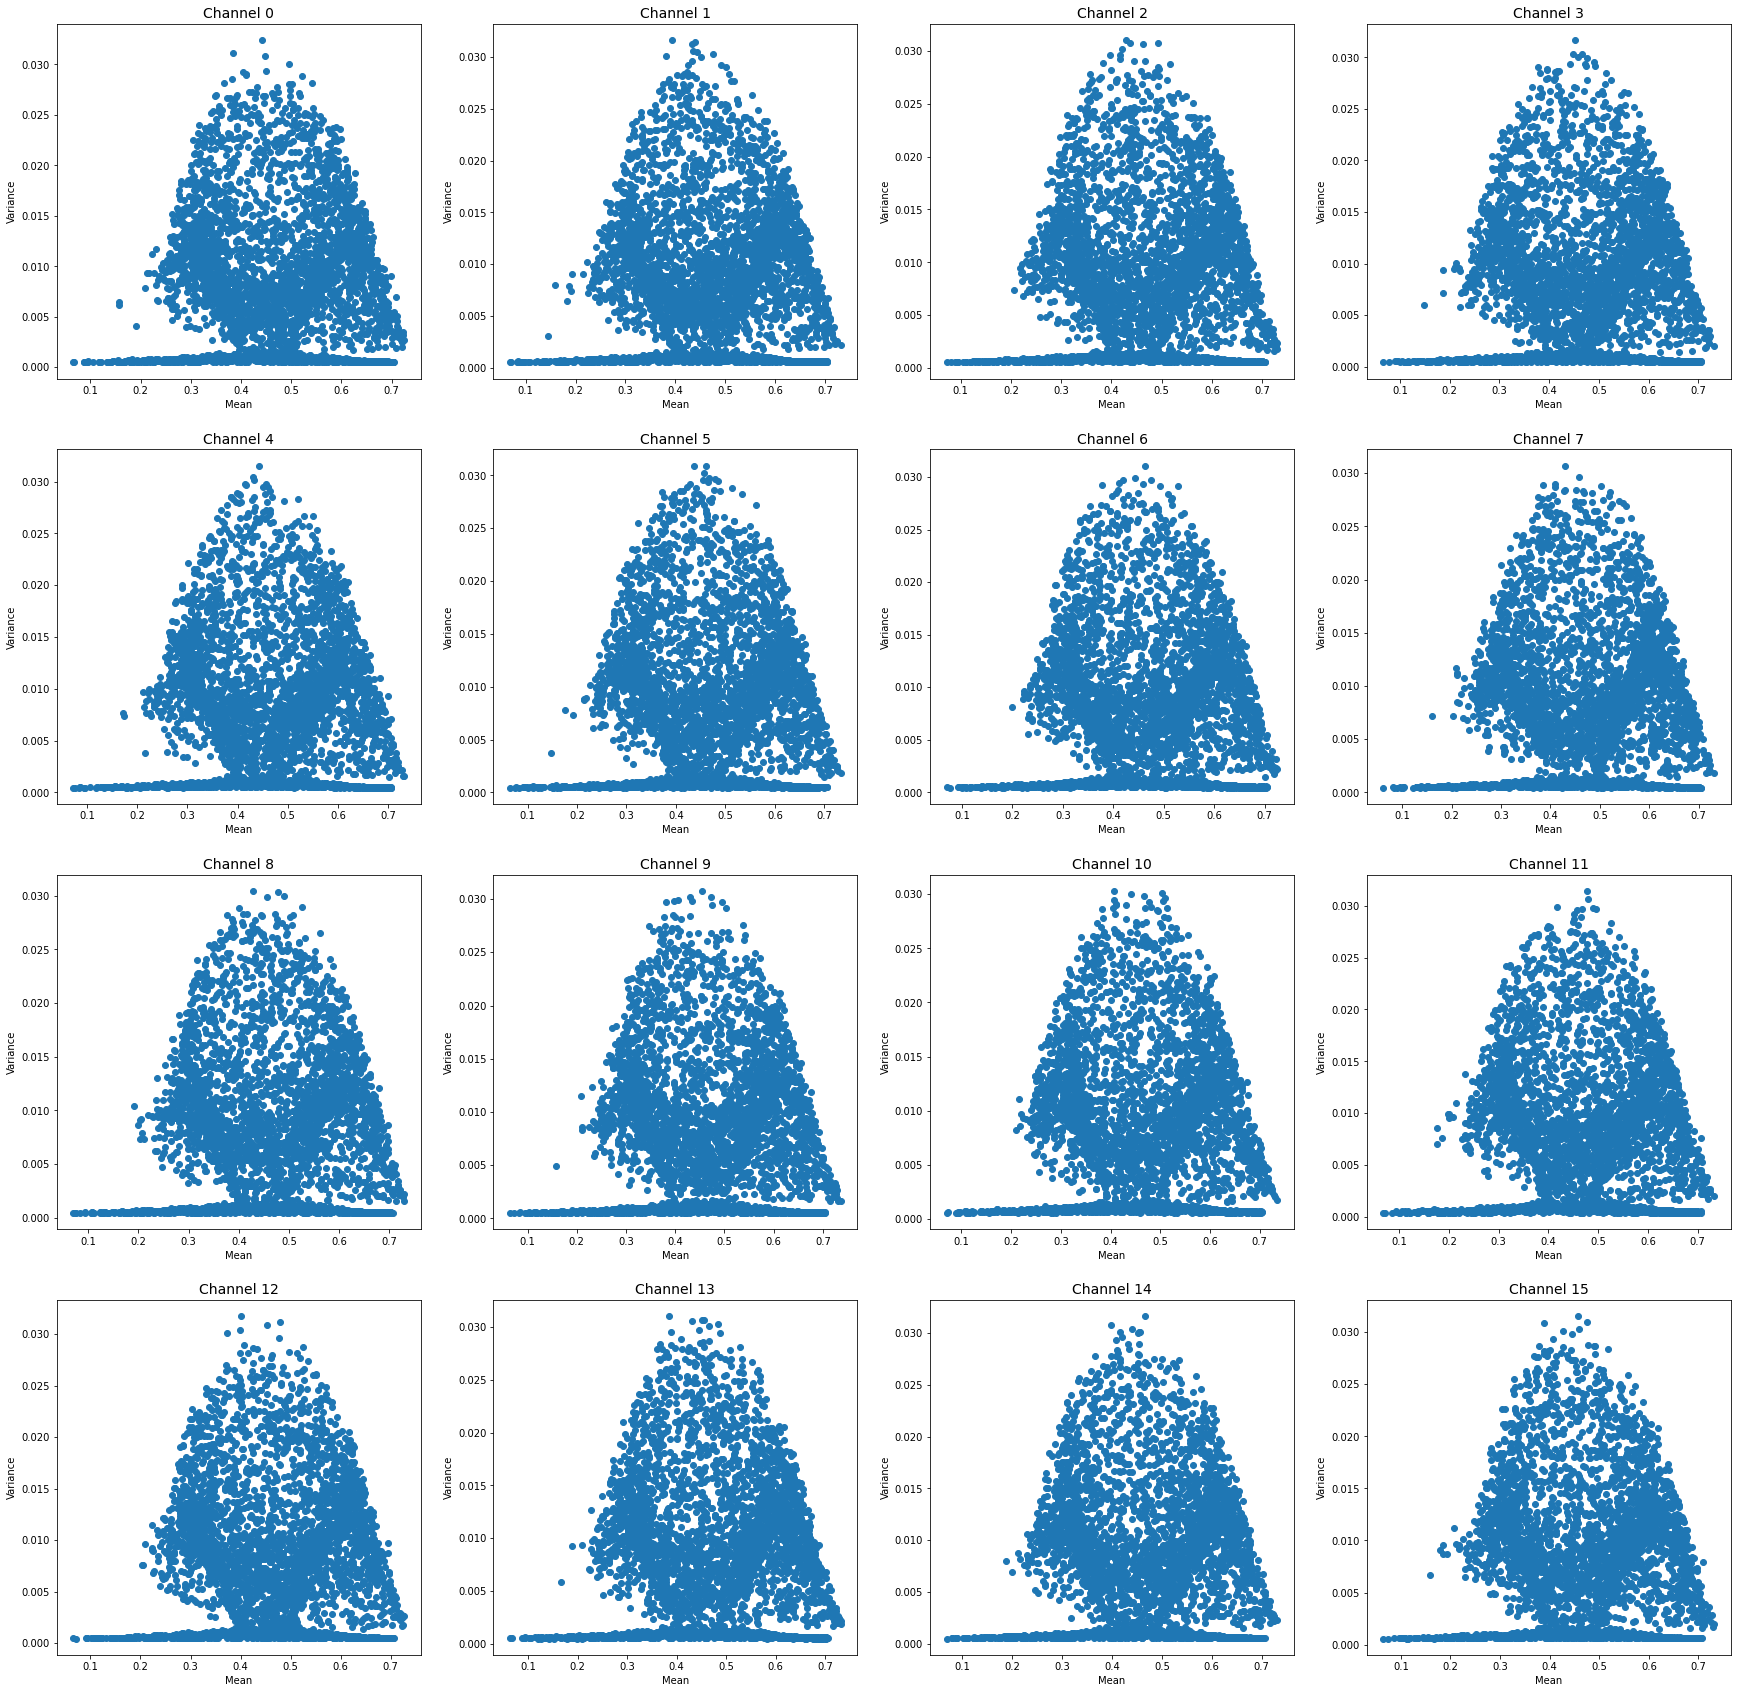

In [66]:
plt.rcParams['figure.figsize'] = [30, 30]
fig, axs = plt.subplots(4,4)

for i in range(4):
    for j in range(4):
        
        cur_channel = (i*4) + j
        axs[i][j].scatter(means[cur_channel], variances[cur_channel])
        axs[i][j].set_xlabel('Mean')
        axs[i][j].set_ylabel('Variance')
        axs[i][j].set_title(f'Channel {cur_channel}', fontsize = 14)

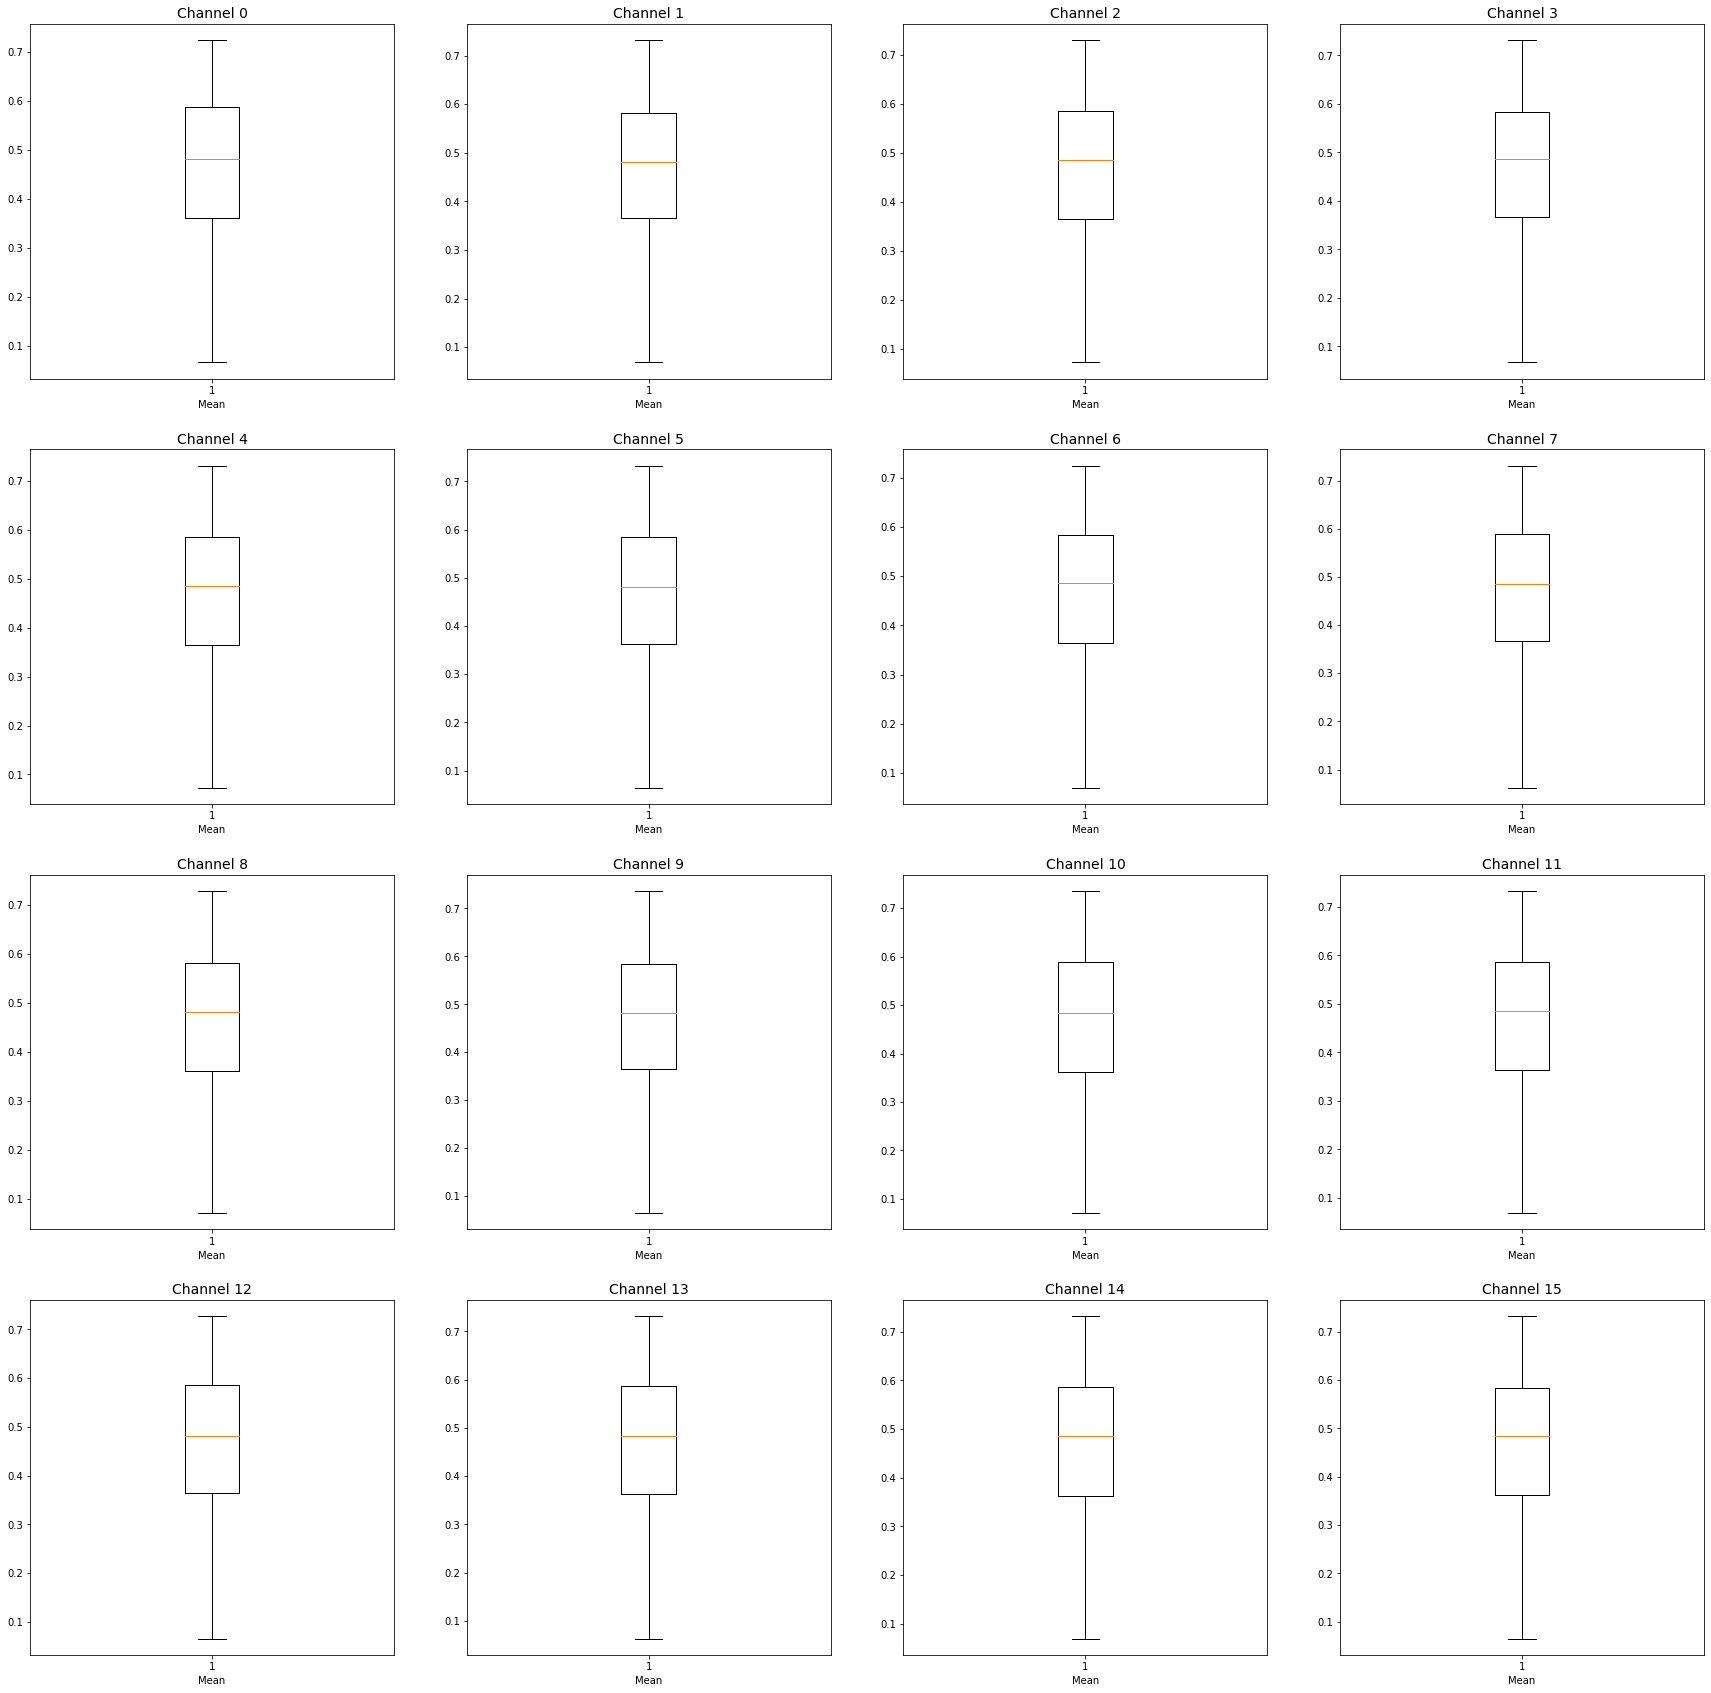

In [67]:
plt.rcParams['figure.figsize'] = [30, 30]
fig, axs = plt.subplots(4,4)

for i in range(4):
    for j in range(4):
        
        cur_channel = (i*4) + j
        axs[i][j].boxplot(means[cur_channel])
        axs[i][j].set_xlabel('Mean')
        axs[i][j].set_title(f'Channel {cur_channel}', fontsize = 14)

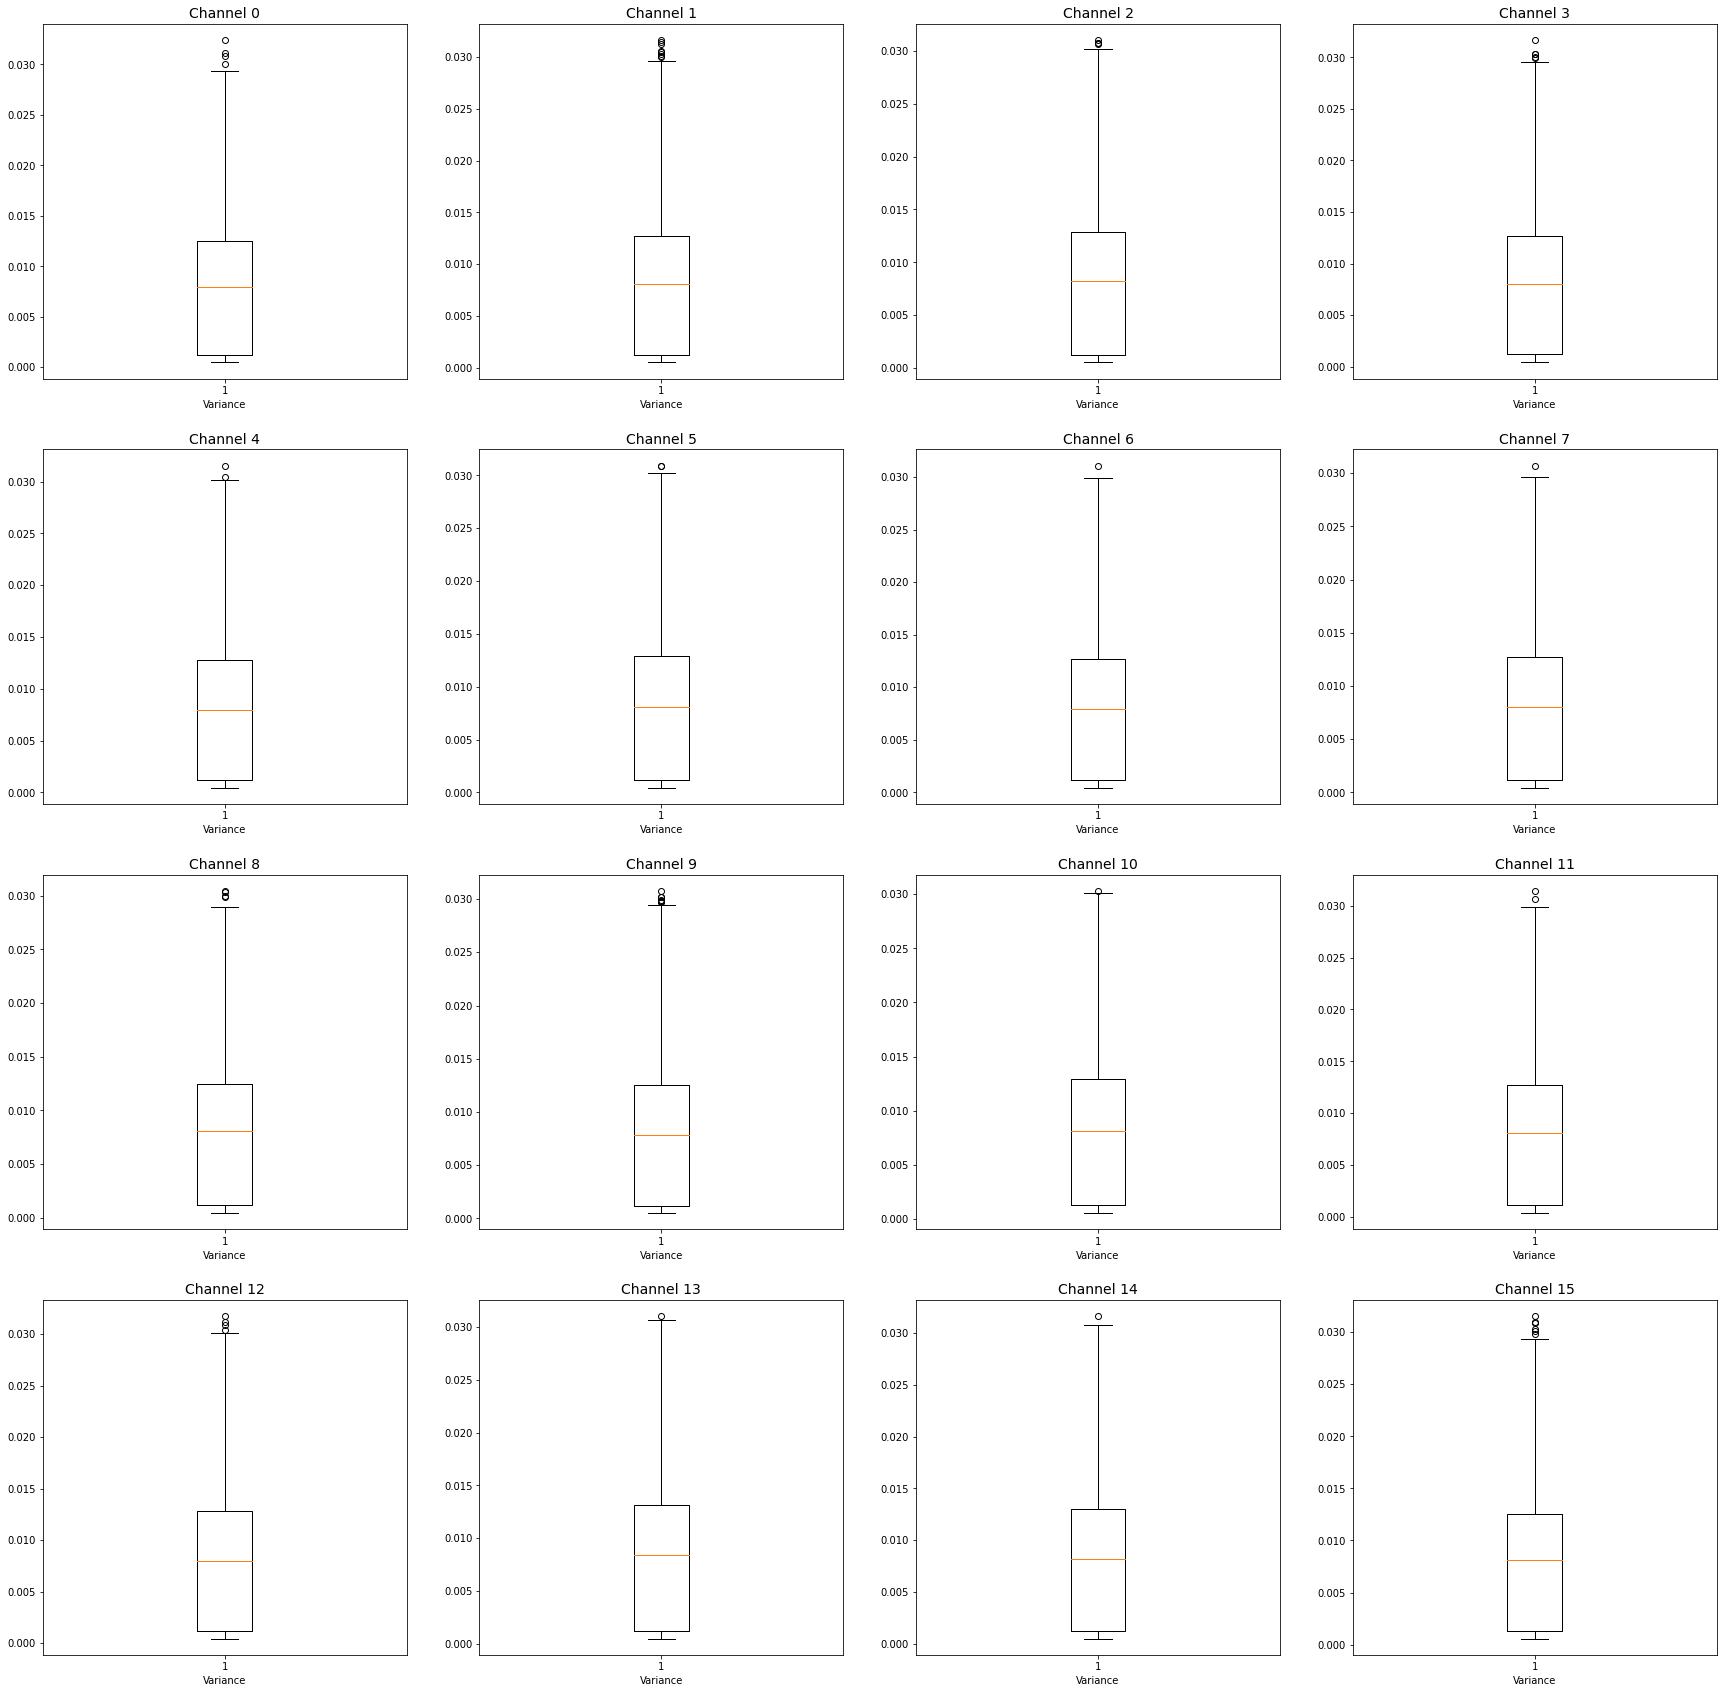

In [68]:
plt.rcParams['figure.figsize'] = [30, 30]
fig, axs = plt.subplots(4,4)

for i in range(4):
    for j in range(4):
        
        cur_channel = (i*4) + j
        axs[i][j].boxplot(variances[cur_channel])
        axs[i][j].set_xlabel('Variance')
        axs[i][j].set_title(f'Channel {cur_channel}', fontsize = 14)

## Observations:

- Distribution of mean is quite similar for all frequency channels
- Distribution of variance is quite similar for all frequency channels, just that some channels may have more outliers on the high side as compared to others (e.g., Cluster 1, 12 or 15)

### Methodology for work ahead

- Design a MLR DNN for mean
    - Input shape: (3,) --> [x,y,z] coordinates
    - Output shape (16,) --> [mu1, .. mu16] where each mu is the mean for each frequency channel at that reference point
    
- Design a MLR DNN for variance
    - Input shape: (3,) --> [x,y,z] coordinates
    - Output shape (16,) --> [sigma1, .. sigma16] where each sigma is the variance for each frequency channel at that reference point

In [256]:
import os
import numpy as np
import h5py
import matplotlib.pyplot as plt
import math

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import Model

In [257]:
print(os.getcwd())
os.chdir('../datasets')
print(os.getcwd())

/home/jovyan/committed_git/data_augmentation
/home/jovyan/committed_git/datasets


In [258]:
# Prepare inputs for the model
def mlr_processds(filename, variable = 'mean'):
    
    # Open HDF5 file and access the dataset
    hdf5_file = h5py.File(filename, 'r')

    features_dataset = hdf5_file['features']
    labels_dataset = hdf5_file['labels']['position']

    # Convert HDF5 dataset to NumPy array
    features = np.array(features_dataset)
    labels = np.array(labels_dataset)

    # Prepare features for dataset
    # Retrieve features from the first UE and transpose the individual matrix
    features_transposed = np.zeros((3876,193,16), dtype = np.float64)
    for i in range(len(features)):
        features_transposed[i] = features[i][0].T

    '''
    # Prepare labels for dataset
    count = 0
    rp_dict = {}
    # For labels, have a shape of (1,) where that number represents the class of that coordinate

    for label in labels:
        rp_dict[count] = label
        count += 1

    labels = np.array([i for i in range(3876)])
    '''
    
    # Close the HDF5 file
    hdf5_file.close()
    
    reduced_features = []
    # Reduce the fingerprints to the means of each channel frequency
    if variable == 'mean':
        for feature in features_transposed:
            reduced_features.append(np.mean(feature[:,0], axis = 0))
    
    elif variable == 'var':
        for feature in features_transposed:
            reduced_features.append(np.var(feature[:,0], axis = 0))
    
    reduced_features = np.array(reduced_features)
    
    print(reduced_features.shape)
    print(labels.shape)
    
    return (reduced_features, labels)

In [259]:
# filename = 'dataset_SNR10_outdoor.mat'
mean_snr10, labels_snr10 = mlr_processds('dataset_SNR10_outdoor.mat', 'mean')
var_snr10, labels_snr10 = mlr_processds('dataset_SNR10_outdoor.mat', 'var')

mean_snr20, labels_snr20 = mlr_processds('dataset_SNR20_outdoor.mat', 'mean')
var_snr20, labels_snr20 = mlr_processds('dataset_SNR20_outdoor.mat', 'var')

mean_snr50, labels_snr50 = mlr_processds('dataset_SNR50_outdoor.mat', 'mean')
var_snr50, labels_snr50 = mlr_processds('dataset_SNR50_outdoor.mat', 'var')

(3876,)
(3876, 3)
(3876,)
(3876, 3)
(3876,)
(3876, 3)
(3876,)
(3876, 3)
(3876,)
(3876, 3)
(3876,)
(3876, 3)


In [260]:
means = np.concatenate((mean_snr10, mean_snr20, mean_snr50), axis = 0)
variances = np.concatenate((var_snr10, var_snr20, var_snr50), axis = 0)
labels = np.concatenate((labels_snr10, labels_snr20, labels_snr50), axis = 0)

In [261]:
# Try out on mean first
# random_state = 42 to always ensure same split of dataset
from sklearn.model_selection import train_test_split

X = labels
y = means
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size = 0.125, random_state=42, shuffle = True)

In [262]:
print(os.getcwd())
os.chdir('../data_augmentation')
print(os.getcwd())

/home/jovyan/committed_git/datasets
/home/jovyan/committed_git/data_augmentation


In [263]:
def fc_block(x):
    
    x = Dense(units = 64, activation = 'tanh')(x)
    x = Dense(units = 128, activation = 'tanh')(x)
    x = Dense(units = 256, activation = 'tanh')(x)
    x = Dense(units = 1, activation = 'linear')(x)
    
    return x

# Note: In original paper, least_squared_error was calculated with one y_true and one y_pred
def least_squared_error(y_true, y_pred):
    
    '''
    y_true = tf.cast(y_true, dtype = 'float64')
    y_pred = tf.cast(y_pred, dtype = 'float64')
    num_channels = len(y_true)
    
    return (1/num_channels)*tf.sqrt((y_pred - y_true) ** 2)
    '''
    
    return tf.sqrt((y_pred - y_true) ** 2)

In [264]:
class ValidationCallback(tf.keras.callbacks.Callback):
    
    def __init__(self, X_val, Y_val, cur_val_loss, val_loss_threshold):
        super(ValidationCallback, self).__init__()
        self.X_val = X_val
        self.Y_val = Y_val
        self.cur_val_loss = cur_val_loss
        self.val_loss_threshold = val_loss_threshold        
    
    def on_epoch_end(self, epoch, logs = None):
        
        # first return value is loss, second return value is selected metrics in model.compile
        val_loss, val_rmse = self.model.evaluate(self.X_val, self.Y_val, verbose = 0)
        
        # Find out absolute difference in mean for each of the frequency channel
        # Useful to diagnose if it's specific frequency channels that are causing large errors later on
        Y_pred = self.model.predict(self.X_val, verbose = 0)
        abs_diff = np.abs(self.Y_val - Y_pred)
        # abs_diff = np.mean(abs_diff, axis = 0)
        logs['abs_diff'] = abs_diff
        logs['val_loss'] = val_loss
        
        if val_loss < self.cur_val_loss and val_loss < self.val_loss_threshold:
            self.model.save('mlr_augmentds_model.h5')
            self.cur_val_loss = val_loss

In [265]:
class MLR_Model:
    
    def __init__(self):
        
        model_input = Input(shape = (3,))
        model_output = fc_block(model_input)
        model = Model(model_input, model_output)
        
        optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
        model.compile(optimizer = 'adam', loss = least_squared_error, metrics = [tf.keras.metrics.MeanAbsoluteError()])
        model.summary()
        
        self.model = model
        
    def train_model(self):
        
        val_callback = ValidationCallback(X_val, y_val, math.inf, 1)
        hist = self.model.fit(X_train, y_train,
                             epochs = 100,
                             batch_size =32,
                             callbacks = [val_callback])
        
        return hist
    
    def test_model(self):
        
        self.model = keras.model.load_model(filename)
        y_pred = self.model.predict(X_test, verbose = 0)
        return y_pred

In [266]:
mean_mlr_model = MLR_Model()

Model: "model_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_40 (InputLayer)       [(None, 3)]               0         
                                                                 
 dense_156 (Dense)           (None, 64)                256       
                                                                 
 dense_157 (Dense)           (None, 128)               8320      
                                                                 
 dense_158 (Dense)           (None, 256)               33024     
                                                                 
 dense_159 (Dense)           (None, 1)                 257       
                                                                 
Total params: 41,857
Trainable params: 41,857
Non-trainable params: 0
_________________________________________________________________


In [267]:
trg_results = mean_mlr_model.train_model()

Epoch 1/100
255/255 [==============================] - 2s 9ms/step - loss: 0.1479 - mean_absolute_error: 0.1479 - abs_diff: 0.1264 - val_loss: 0.1280
Epoch 2/100
255/255 [==============================] - 2s 9ms/step - loss: 0.1236 - mean_absolute_error: 0.1236 - abs_diff: 0.1161 - val_loss: 0.1157
Epoch 3/100
255/255 [==============================] - 2s 8ms/step - loss: 0.1214 - mean_absolute_error: 0.1214 - abs_diff: 0.1182 - val_loss: 0.1164
Epoch 4/100
255/255 [==============================] - 2s 8ms/step - loss: 0.1180 - mean_absolute_error: 0.1180 - abs_diff: 0.1198 - val_loss: 0.1185
Epoch 5/100
255/255 [==============================] - 2s 8ms/step - loss: 0.1168 - mean_absolute_error: 0.1168 - abs_diff: 0.1251 - val_loss: 0.1246
Epoch 6/100
255/255 [==============================] - 2s 8ms/step - loss: 0.1167 - mean_absolute_error: 0.1167 - abs_diff: 0.1166 - val_loss: 0.1154
Epoch 7/100
255/255 [==============================] - 2s 8ms/step - loss: 0.1161 - mean_absolute_er

In [270]:
print(trg_results)

Text(0.5, 1.0, 'Loss')

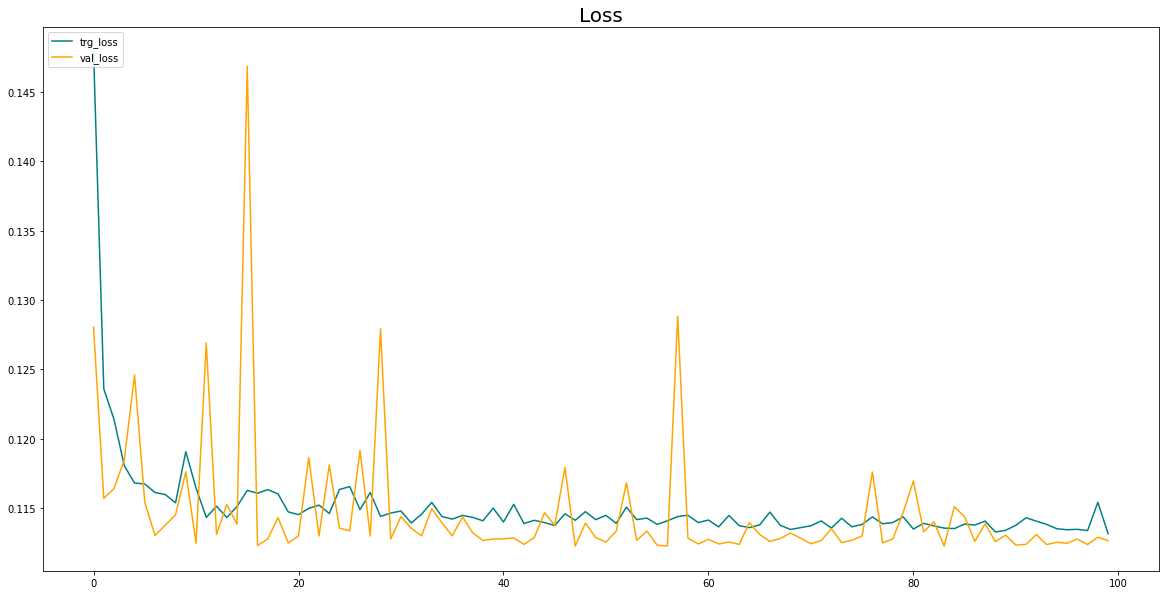

In [271]:
loss = trg_results.history['loss']
val_loss = trg_results.history['val_loss']
epochs = [i for i in range(len(loss))]

plt.rcParams['figure.figsize'] = [20, 10]

plt.plot(epochs, loss, color='teal', label='trg_loss')
plt.plot(epochs, val_loss, color='orange', label='val_loss')
plt.legend(loc='upper left')
plt.title('Loss', fontsize=20)